In [1]:
import os
import re
import json
import subprocess
import matplotlib.pyplot as plt

from Bio import Entrez
from Bio import SeqIO
from Bio import Phylo
from Bio.Align.Applications import MuscleCommandline
from Bio.Phylo.Applications import PhymlCommandline

Entrez.email = "khamitov.dr15@physics.msu.ru" # Исправить на свой адрес

## Определяем интересующие нас штаммы

Перечисляем названия организмов и штаммы, для которых хотим строить дерево (штамм можно не указывать)

In [2]:
organisms = [ # (organism, strain)
    ('Archaeoglobus fulgidus', 'VC-16'),
    ('Desulfovibrio piger', 'ATCC 29098'),
    ('Herpetosiphon aurantiacus', None),
    ('Ignicoccus hospitalis', 'KIN4/I'),
    ('Methanocaldococcus jannaschii', 'JCM 10045'),
    ('Methanococcus maripaludis', 'JJ'),
    ('Decoy', 'junk'),    # Такого в базах точно нет, скрипт отработает с предупреждением
    ('Pyrobaculum aerophilum', 'IM2'),
    ('Pyrobaculum calidifontis', 'VA1'),
    ('Pyrococcus horikoshii', 'JA-1'),
    ('Rhodopirellula baltica', 'SH 1'),
    ('Sulfolobus tokodaii', '7'),
]

## Получение данных из RefSeq

In [3]:
# 16S RefSeq Nucleotide sequence records
# https://www.ncbi.nlm.nih.gov/refseq/targetedloci/16S_process/
REFSEQ_16S_RNA_TERM = '33175[BioProject] OR 33317[BioProject]'

# Задаем имена файлов
RAW_SEQ_FILENAME = '16S_sequences.fasta'
ALIGNEMENT_FILENAME = '16S_sequences_aligned.fasta'
BLOCKS_FILENAME = '16S_sequences_blocks.phylip'
ML_TREE_NAME = 'Bacteria_MLTree.newick'

In [4]:
full_names = {} # словарь с полными именами
with open(RAW_SEQ_FILENAME, 'w') as output_handle:
    for organism, strain in organisms:
        
        # Запрос к базе данных
        query = f'"{organism}"[Organism]'
        if strain:
            query += f' AND "{strain}"[Strain]'
        
        # Выполняем поиск
        handle = Entrez.esearch(db='nucleotide',
                                term=f'({REFSEQ_16S_RNA_TERM}) AND ({query})',
                                sort='Date Modified')
        record = Entrez.read(handle)
        
        # Проверка на то, нашлось ли что-либо по запросу
        if int(record["Count"]) == 0:
            print(f'Warning! No items found for {organism} {strain}\n')
            continue
        
        # Выбираем самый свежий результат и получаем последовательность
        seq_id = record['IdList'][0]
        handle = Entrez.efetch(db='nucleotide', 
                               id=seq_id,
                               rettype="fasta")
        seq = SeqIO.read(handle, format='fasta')
        
        # В ходе обработки будем использовать короткие имена
        full_names[seq.id] = seq.description
        print(f'For        "{organism} {strain}" was retrieved:\n{seq.description}\n')
        seq.description = ''
        
        # Записываем последовательность в файл
        SeqIO.write(seq, output_handle, "fasta")

For        "Archaeoglobus fulgidus VC-16" was retrieved:
NR_118873.1 Archaeoglobus fulgidus DSM 4304 strain VC-16 16S ribosomal RNA, complete sequence

For        "Desulfovibrio piger ATCC 29098" was retrieved:
NR_041778.1 Desulfovibrio piger strain ATCC 29098 16S ribosomal RNA, partial sequence

For        "Herpetosiphon aurantiacus None" was retrieved:
NR_074236.1 Herpetosiphon aurantiacus 16S ribosomal RNA, partial sequence

For        "Ignicoccus hospitalis KIN4/I" was retrieved:
NR_074104.1 Ignicoccus hospitalis strain KIN4/I 16S ribosomal RNA, complete sequence

For        "Methanocaldococcus jannaschii JCM 10045" was retrieved:
NR_113292.1 Methanocaldococcus jannaschii strain JCM 10045 16S ribosomal RNA, partial sequence

For        "Methanococcus maripaludis JJ" was retrieved:
NR_104984.1 Methanococcus maripaludis strain JJ 16S ribosomal RNA, partial sequence

Warning! No items found for Decoy junk

For        "Pyrobaculum aerophilum IM2" was retrieved:
NR_102764.2 Pyrobaculum 

## Выравнивание с помощью MUSCLE

In [5]:
# Обертка версии MUSCLE для командной стоки (программа должна быть установлена в системе)
muscle_cline = MuscleCommandline(
    input=RAW_SEQ_FILENAME,
    out=ALIGNEMENT_FILENAME,
)
stdout, stderr = muscle_cline()
print(stderr)


MUSCLE v3.8.1551 by Robert C. Edgar

http://www.drive5.com/muscle
This software is donated to the public domain.
Please cite: Edgar, R.C. Nucleic Acids Res 32(5), 1792-97.

16S_sequences 11 seqs, lengths min 1400, max 1542, avg 1477
00:00:00    15 MB(-1%)  Iter   1    1.52%  K-mer dist pass 1
00:00:00    15 MB(-1%)  Iter   1  100.00%  K-mer dist pass 1
00:00:00    15 MB(-1%)  Iter   1    1.52%  K-mer dist pass 2
00:00:00    15 MB(-1%)  Iter   1  100.00%  K-mer dist pass 2
00:00:00    17 MB(-1%)  Iter   1   10.00%  Align node       
00:00:00    24 MB(-2%)  Iter   1   20.00%  Align node
00:00:00    25 MB(-2%)  Iter   1   30.00%  Align node
00:00:00    27 MB(-2%)  Iter   1   40.00%  Align node
00:00:00    27 MB(-2%)  Iter   1   50.00%  Align node
00:00:00    28 MB(-2%)  Iter   1   60.00%  Align node
00:00:00    28 MB(-2%)  Iter   1   70.00%  Align node
00:00:00    30 MB(-2%)  Iter   1   80.00%  Align node
00:00:00    30 MB(-2%)  Iter   1   90.00%  Align node
00:00:00    31 MB(-2%)  Iter 

## Фильтруем выравнивания с помощью gBlocks

In [6]:
# Выполняем bash-команду
!./Gblocks 16S_sequences_aligned.fasta g

# Переводим результат в формат phylip
SeqIO.convert(f'{ALIGNEMENT_FILENAME}-gb', 'fasta',
              BLOCKS_FILENAME, 'phylip-relaxed')

os.remove(f'{ALIGNEMENT_FILENAME}-gb') # удаляем старый файл


11 sequences and 1638 positions in the first alignment file:
16S_sequences_aligned.fasta

16S_sequences_aligned.fasta
Original alignment: 1638 positions
Gblocks alignment:  1194 positions (72 %) in 26 selected block(s)



## Строим дерево методом максимального правдоподобия

In [7]:
# Обертка версии MUSCLE для командной стоки (программа должна быть установлена в системе)
command_tree = PhymlCommandline(
    input=BLOCKS_FILENAME,
    search='BEST',
    datatype='nt',
)
stdout, stderr = command_tree()

# Печатаем отчет программы
with open(f'{BLOCKS_FILENAME}_phyml_stats.txt', 'r') as report:
    print(report.read())
    
# Удаляем ненужное и переименовываем файлы
os.remove(f'{BLOCKS_FILENAME}_phyml_stats.txt')
os.rename(f'{BLOCKS_FILENAME}_phyml_tree.txt', ML_TREE_NAME)


 oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo
                                  ---  PhyML 3.3.3:3.3.20190909-1  ---                                             
                              http://www.atgc-montpellier.fr/phyml                                          
                             Copyright CNRS - Universite Montpellier                                 
 oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo

. Sequence filename: 			16S_sequences_blocks.phylip
. Data set: 				#1
. Initial tree: 			BioNJ
. Model of nucleotides substitution: 	HKY85
. Number of taxa: 			11
. Log-likelihood: 			-7173.18256
. Unconstrained log-likelihood: 	-5385.19286
. Composite log-likelihood: 		-17696.97011
. Parsimony: 				1330
. Tree size: 				1.59740
. Discrete gamma model: 		Yes
  - Number of classes: 			4
  - Gamma shape parameter: 		0.579
  - Relative rate in class 1: 		0.04882 [freq=0.25

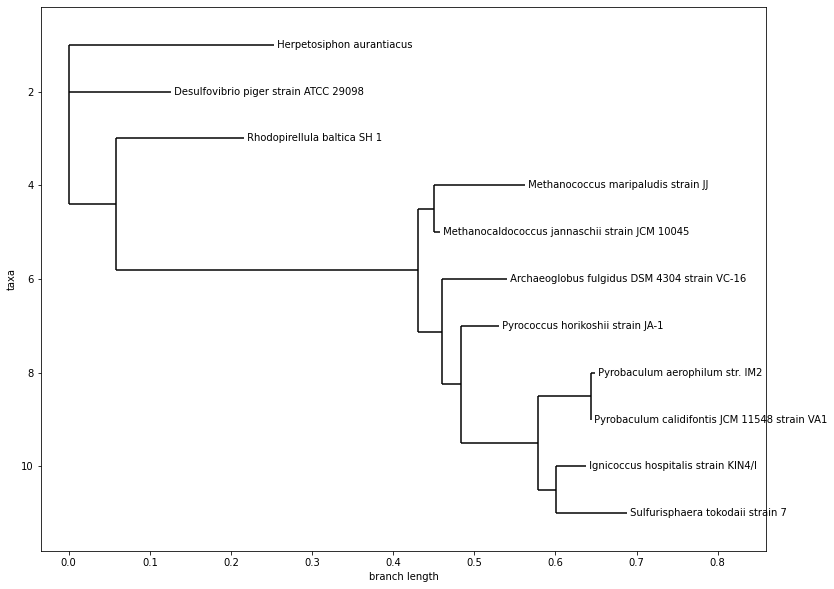

In [8]:
# Функция, возвращающая полные названия для узлов
def label_func(node):
    key = str(node)
    if key in full_names:
        label = full_names[key]
        return re.match(r'.+? (.+?) 16S', label).groups()[0]
    return ''


# Считываем полученное дерево
tree = Phylo.read(ML_TREE_NAME, 'newick')
tree.ladderize()  # Flip branches so deeper clades are displayed at top

# Строим полученное дерево
fig, ax = plt.subplots(figsize=(13,10))
Phylo.draw(tree,
           label_func=label_func,
           branch_labels=lambda x: '',
           axes=ax,
          )